In [1]:
import os
from itertools import combinations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import optuna

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import lightgbm as lgbm
import xgboost as xgb
import seaborn as sns

optuna.logging.set_verbosity(optuna.logging.WARNING)
import warnings
warnings.filterwarnings('ignore')

from lightgbm import *
pd.set_option("display.max_columns", None)
import time
import numba
import gc

In [2]:
df = pd.read_csv('/kaggle/input/optiver-trading-at-the-close/train.csv')

In [3]:
df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0,0_0_4


In [4]:
df.isna().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

In [5]:
df.dropna(subset=['target', 'wap'], inplace=True)

In [6]:
df.isna().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                   0
imbalance_buy_sell_flag          0
reference_price                  0
matched_size                     0
far_price                  2894122
near_price                 2856960
bid_price                        0
bid_size                         0
ask_price                        0
ask_size                         0
wap                              0
target                           0
time_id                          0
row_id                           0
dtype: int64

In [7]:
IS_ONLINE = True

In [8]:
def reduce_mem_usage(df, cols=None): 
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage of dataframe is {start_mem:.2f} MB')
    
    if cols == None:
        cols = df.columns
    for col in cols:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)
    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization is: {end_mem:.2f} MB')
    decrease = 100 * (start_mem - end_mem) / start_mem
    print(f'Decreased by {decrease:.2f}%')
    
    return df

In [9]:
if not IS_ONLINE:
    target_std = df.iloc[:3928320][['stock_id', 'target']].groupby('stock_id').std().reset_index().rename(columns={'target' : 'target_volatility'})
else:
    target_std = df[['stock_id', 'target']].groupby('stock_id').std().reset_index().rename(columns={'target' : 'target_volatility'})

In [10]:
best_imb1_feats = ['wap+near_price_imb1', 'bid_price+reference_price_imb1', 'bid_price+near_price_imb1', 'ask_price+near_price_imb1', 'ask_price+reference_price_imb1', 'target_volatility+imbalance_size_matched_size_div_imb1', 'imbalance_buy_sell_flag+seconds_in_bucket_imb1', 'near_price+reference_price_imb1', 'wap+bid_price_imb1', 'target_volatility+imbalance_buy_sell_flag_imb1', 'target_volatility+near_price_imb1', 'wap+reference_price_imb1', 'target_volatility+ask_price_imb1', 'imbalance_size_matched_size_div+near_price_imb1', 'target_volatility+reference_price_imb1', 'wap+ask_price_imb1', 'target_volatility+seconds_in_bucket_imb1', 'target_volatility+bid_price_imb1', 'ask_price+bid_price_imb1', 'target_volatility+wap_imb1', 'imbalance_size_matched_size_div+seconds_in_bucket_imb1', 'bid_price_ask_price_diff+reference_price_wap_diff_imb1', 'imbalance_size_matched_size_div+bid_price_ask_price_diff_imb1', 'target_volatility+far_price_imb1', 'imbalance_size_matched_size_div+far_price_imb1', 'imbalance_size_matched_size_div+imbalance_buy_sell_flag_imb1', 'bid_price+seconds_in_bucket_imb1', 'far_price+imbalance_buy_sell_flag_imb1', 'wap+imbalance_buy_sell_flag_imb1', 'ask_price+imbalance_buy_sell_flag_imb1', 'matched_size+imbalance_size_imb1', 'bid_price_ask_price_diff+far_price_imb1', 'imbalance_size_matched_size_div+near_price_far_price_diff_imb1', 'bid_price+imbalance_buy_sell_flag_imb1', 'reference_price+imbalance_buy_sell_flag_imb1', 'reference_price+seconds_in_bucket_imb1', 'imbalance_size_matched_size_div+reference_price_wap_diff_imb1', 'bid_price_ask_price_diff+imbalance_buy_sell_flag_imb1', 'near_price+seconds_in_bucket_imb1', 'near_price+imbalance_buy_sell_flag_imb1', 'wap+seconds_in_bucket_imb1', 'far_price+seconds_in_bucket_imb1', 'reference_price_wap_diff+reference_price_imb1', 'imbalance_size_signed+matched_size_imb1', 'reference_price_wap_diff+wap_imb1', 'matched_size_bid_ask_size_div+imbalance_size_matched_size_div_imb1', 'ask_price+seconds_in_bucket_imb1', 'imbalance_size_matched_size_div+reference_price_imb1', 'bid_size_ask_size_div+bid_price_ask_price_diff_imb1', 'bid_size+seconds_in_bucket_imb1', 'ask_size+matched_size_imb1', 'ask_price+far_price_imb1', 'reference_price_wap_diff+bid_price_imb1', 'bid_price+far_price_imb1', 'target_volatility+bid_size_ask_size_div_imb1', 'matched_size_bid_ask_size_div+seconds_in_bucket_imb1', 'matched_size_bid_ask_size_div+bid_price_ask_price_diff_imb1', 'imbalance_size_matched_size_div+bid_price_imb1', 'imbalance_size_matched_size_div+wap_imb1', 'bid_size_ask_size_div+reference_price_wap_diff_imb1', 'ask_size+seconds_in_bucket_imb1', 'matched_size_bid_ask_size_div+far_price_imb1', 'imbalance_size_matched_size_div+ask_price_imb1', 'matched_size_bid_ask_size_div+near_price_imb1', 'matched_size_bid_ask_size_div+imbalance_buy_sell_flag_imb1', 'reference_price_wap_diff+ask_price_imb1', 'far_price+reference_price_imb1', 'wap+far_price_imb1', 'matched_size_bid_ask_size_div+bid_size_ask_size_div_imb1', 'matched_size_bid_ask_size_div+imbalance_size_signed_ask_size_div_imb1', 'imbalance_size_signed_ask_size_div+imbalance_size_matched_size_div_imb1', 'near_price_far_price_diff+imbalance_buy_sell_flag_imb1', 'reference_price_wap_diff+imbalance_buy_sell_flag_imb1', 'bid_price_ask_price_diff+bid_price_imb1', 'bid_price_ask_price_diff+ask_price_imb1', 'imbalance_size_signed_ask_size_div+near_price_imb1', 'bid_price_ask_price_diff+reference_price_imb1', 'near_price_far_price_diff+reference_price_imb1', 'imbalance_size_signed_ask_size_div+near_price_far_price_diff_imb1', 'bid_size_ask_size_div+reference_price_imb1', 'bid_size_ask_size_div+seconds_in_bucket_imb1', 'ask_size+bid_size_imb1', 'near_price+far_price_imb1', 'near_price_far_price_diff+bid_price_imb1', 'bid_price_ask_price_diff+near_price_far_price_diff_imb1', 'matched_size_bid_ask_size_div+bid_size_imb1', 'bid_size+matched_size_imb1', 'imbalance_size_signed+seconds_in_bucket_imb1', 'target_volatility+reference_price_wap_diff_imb1', 'imbalance_size_signed_bid_size_div+imbalance_size_matched_size_div_imb1', 'target_volatility+matched_size_bid_ask_size_div_imb1', 'target_volatility+imbalance_size_signed_ask_size_div_imb1', 'imbalance_size_signed_bid_size_div+near_price_imb1', 'imbalance_size_signed_ask_size_div+imbalance_buy_sell_flag_imb1', 'bid_size_ask_size_div+imbalance_buy_sell_flag_imb1', 'imbalance_size_signed_ask_size_div+far_price_imb1', 'imbalance_size_signed_ask_size_div+ask_size_imb1', 'near_price_far_price_diff+far_price_imb1', 'matched_size_bid_ask_size_div+ask_size_imb1', 'target_volatility+near_price_far_price_diff_imb1', 'bid_size_ask_size_div+ask_size_imb1', 'imbalance_size_signed_bid_size_div+imbalance_buy_sell_flag_imb1', 'bid_price_ask_price_diff+near_price_imb1', 'imbalance_size_signed_ask_size_div+seconds_in_bucket_imb1', 'matched_size_bid_ask_size_div+bid_price_imb1', 'near_price_far_price_diff+near_price_imb1', 'bid_size_ask_size_div+ask_price_imb1', 'bid_price_ask_price_diff+wap_imb1', 'target_volatility+bid_size_imb1', 'target_volatility+imbalance_size_signed_bid_size_div_imb1', 'imbalance_size_signed_ask_size_div+bid_price_imb1', 'imbalance_size_signed_ask_size_div+ask_price_imb1', 'imbalance_size_signed_bid_size_div+bid_size_imb1', 'bid_size+imbalance_size_imb1', 'bid_size_ask_size_div+bid_price_imb1', 'imbalance_size_signed+ask_size_imb1', 'target_volatility+bid_price_ask_price_diff_imb1', 'near_price_far_price_diff+ask_price_imb1', 'reference_price_wap_diff+near_price_imb1', 'imbalance_size_signed_ask_size_div+reference_price_imb1', 'imbalance_size_signed_bid_size_div+ask_size_imb1', 'bid_size_ask_size_div+wap_imb1', 'matched_size_bid_ask_size_div+imbalance_size_signed_imb1', 'imbalance_size_signed_bid_size_div+near_price_far_price_diff_imb1', 'reference_price_wap_diff+far_price_imb1', 'matched_size_bid_ask_size_div+wap_imb1', 'matched_size_bid_ask_size_div+reference_price_wap_diff_imb1', 'matched_size+seconds_in_bucket_imb1', 'imbalance_size_signed_ask_size_div+wap_imb1', 'imbalance_size_signed_ask_size_div+imbalance_size_signed_bid_size_div_imb1', 'imbalance_size_signed_ask_size_div+bid_price_ask_price_diff_imb1', 'near_price_far_price_diff+wap_imb1', 'matched_size_bid_ask_size_div+ask_price_imb1', 'imbalance_size_signed_bid_size_div+seconds_in_bucket_imb1', 'bid_size_ask_size_div+imbalance_size_matched_size_div_imb1', 'bid_size_ask_size_div+imbalance_size_signed_ask_size_div_imb1', 'bid_size_ask_size_div+imbalance_size_signed_bid_size_div_imb1', 'imbalance_size_signed+imbalance_buy_sell_flag_imb1', 'imbalance_size_signed_bid_size_div+bid_price_ask_price_diff_imb1', 'target_volatility+ask_size_imb1', 'matched_size_bid_ask_size_div+imbalance_size_signed_bid_size_div_imb1', 'matched_size_bid_ask_size_div+near_price_far_price_diff_imb1', 'matched_size_bid_ask_size_div+reference_price_imb1', 'near_price_far_price_diff+reference_price_wap_diff_imb1', 'bid_size_ask_size_div+far_price_imb1', 'imbalance_size_signed_bid_size_div+far_price_imb1', 'imbalance_size_signed_bid_size_div+wap_imb1', 'imbalance_size_signed_ask_size_div+bid_size_imb1', 'imbalance_size+seconds_in_bucket_imb1', 'imbalance_size_signed_bid_size_div+bid_price_imb1', 'imbalance_size_signed_bid_size_div+ask_price_imb1', 'bid_size_ask_size_div+near_price_imb1', 'bid_size_ask_size_div+near_price_far_price_diff_imb1', 'imbalance_size_signed_ask_size_div+reference_price_wap_diff_imb1', 'imbalance_size_signed+bid_size_imb1', 'bid_size+far_price_imb1', 'ask_size+imbalance_size_imb1', 'imbalance_size_matched_size_div+bid_size_imb1', 'bid_size+imbalance_buy_sell_flag_imb1', 'imbalance_size_signed_ask_size_div+imbalance_size_signed_imb1', 'matched_size_bid_ask_size_div+imbalance_size_imb1', 'ask_size+bid_price_imb1', 'ask_size+reference_price_imb1', 'imbalance_size_signed_ask_size_div+imbalance_size_imb1', 'imbalance_buy_sell_flag+imbalance_size_imb1', 'imbalance_size_signed_bid_size_div+imbalance_size_imb1', 'imbalance_size_signed_bid_size_div+reference_price_wap_diff_imb1', 'reference_price_wap_diff+seconds_in_bucket_imb1', 'target_volatility+imbalance_size_imb1', 'imbalance_size_signed_bid_size_div+reference_price_imb1', 'imbalance_size_signed_ask_size_div+matched_size_imb1', 'bid_size+reference_price_imb1', 'ask_size+near_price_imb1', 'ask_size+ask_price_imb1', 'ask_size+imbalance_buy_sell_flag_imb1', 'imbalance_size_signed_bid_size_div+imbalance_size_signed_imb1', 'wap+bid_size_imb1', 'imbalance_size_signed_bid_size_div+matched_size_imb1', 'imbalance_size_matched_size_div+ask_size_imb1', 'bid_size_ask_size_div+imbalance_size_imb1', 'ask_size+far_price_imb1', 'imbalance_size_signed+ask_price_imb1', 'ask_price+bid_size_imb1', 'bid_size_ask_size_div+bid_size_imb1', 'bid_size_ask_size_div+imbalance_size_signed_imb1', 'target_volatility+imbalance_size_signed_imb1', 'near_price_far_price_diff+seconds_in_bucket_imb1']
best_movingav_feats = list(set(['bid_price+reference_price_imb1', 'ask_price+reference_price_imb1', 'imbalance_size_signed', 'bid_price_ask_price_diff', 'imbalance_size_signed', 'matched_size_bid_ask_size_div', 'imbalance_size_matched_size_div', 'imbalance_size_signed', 'bid_price_ask_price_diff', 'bid_price_ask_price_diff', 'ask_price', 'imbalance_size_matched_size_div', 'imbalance_size_matched_size_div', 'matched_size_bid_ask_size_div', 'bid_price', 'bid_price', 'ask_price', 'matched_size_bid_ask_size_div', 'ask_price', 'bid_price']))
best_std_feats = list(set(['bid_price_ask_price_diff', 'matched_size_bid_ask_size_div', 'matched_size', 'bid_size', 'ask_size', 'bid_size_ask_size_div', 'bid_price_ask_price_diff', 'ask_price', 'imbalance_size_matched_size_div', 'imbalance_size', 'imbalance_size_signed_bid_size_div', 'reference_price_wap_diff', 'matched_size', 'imbalance_size_signed_ask_size_div', 'near_price', 'imbalance_size_signed', 'bid_price', 'matched_size_bid_ask_size_div', 'near_price_far_price_diff', 'far_price', 'reference_price', 'imbalance_size_signed_ask_size_div', 'imbalance_buy_sell_flag', 'ask_size', 'reference_price_wap_diff', 'bid_size', 'wap', 'bid_price', 'imbalance_size_signed', 'imbalance_size_matched_size_div', 'imbalance_size', 'near_price_far_price_diff', 'imbalance_size_signed_bid_size_div', 'bid_size_ask_size_div', 'ask_price', 'far_price', 'near_price', 'reference_price', 'wap', 'imbalance_buy_sell_flag']))
best_lagged_feats = list(set(['matched_size', 'imbalance_size_signed', 'far_price', 'imbalance_size_matched_size_div', 'near_price', 'near_price_far_price_diff', 'imbalance_size', 'imbalance_size_signed_bid_size_div', 'ask_price', 'bid_price_ask_price_diff', 'bid_price', 'reference_price_wap_diff', 'imbalance_size_signed_ask_size_div', 'reference_price', 'wap', 'bid_size', 'ask_size', 'matched_size_bid_ask_size_div', 'bid_size_ask_size_div', 'imbalance_buy_sell_flag']))
best_momentum_feats = list(set(['matched_size', 'imbalance_size_signed', 'far_price', 'imbalance_size_matched_size_div', 'near_price', 'near_price_far_price_diff', 'imbalance_size', 'imbalance_size_signed_bid_size_div', 'ask_price', 'bid_price_ask_price_diff', 'bid_price', 'reference_price_wap_diff', 'imbalance_size_signed_ask_size_div', 'reference_price', 'wap', 'bid_size', 'ask_size', 'matched_size_bid_ask_size_div', 'bid_size_ask_size_div', 'imbalance_buy_sell_flag']))

def feature_cols(df) :
    cols = [c for c in df.columns if c not in ['row_id', 'time_id', 'date_id', 'date_stock_id', 'currently_scored']]
    df = df[cols]    
    return df

def feature_engineering(df, training=False, last_df=None):
    size = df.shape[0]
    if not training:
        df = pd.concat(last_df + [df], ignore_index=True)
 
    df['reference_price_wap_diff'] = df['reference_price'] - df['wap']
    df['near_price_far_price_diff'] = df['near_price'] - df['far_price']
    df['bid_price_ask_price_diff'] = df['bid_price'] - df['ask_price']
    df['imbalance_size_signed'] = df['imbalance_size'] * df['imbalance_buy_sell_flag']
    df['imbalance_size_matched_size_div'] = df['imbalance_size_signed'] / df['matched_size']
    df['imbalance_size_signed_bid_size_div'] = df['imbalance_size_signed'] / df['bid_size']
    df['imbalance_size_signed_ask_size_div'] = df['imbalance_size_signed'] / df['ask_size']
    df['bid_size_ask_size_div'] = df['bid_size'] / df['ask_size']
    df['matched_size_bid_ask_size_div'] = df['matched_size'] / (df['bid_size'] + df['ask_size'])
    
    df = df.merge(target_std, how='left', on='stock_id')
    
    base_feat = [c for c in df.columns if c not in ['row_id', 'time_id', 'date_id', 'stock_id']]
         
    start_time = time.time()
    for (i, c1) in enumerate(base_feat):
        for (j, c2) in enumerate(base_feat): 
            if c1 + '+' + c2 + '_imb1' in best_imb1_feats:
                df[c1 + '+' + c2 + '_imb1'] = (df[c1] - df[c2]) / (df[c1] + df[c2])   
    if training:
        print(-(start_time - time.time()))
        
    start_time = time.time()
    p = ['wap', 'ask_price', 'bid_price']
    max_ = df[p].max(axis=1)
    min_ = df[p].min(axis=1)
    mid_ = df[p].sum(axis=1)-min_-max_
    df['wap_ask_bid_imb2'] = (max_-mid_)/(mid_-min_) 
    del max_, min_, mid_
    gc.collect()
    if training:
        print(-(start_time - time.time()))
        df = reduce_mem_usage(df)
    
    start_time = time.time()
    a = df[['stock_id'] + q].groupby(['stock_id'], as_index=False).shift(1)
    for (i, c1) in enumerate(best_lagged_feats):
        df[c1 + '+lagged'] = a[c1]
    del a
    gc.collect()
    if training:
        print(-(start_time - time.time()))
    
    start_time = time.time()
    rolling_3 = df[['stock_id'] + q].groupby(['stock_id'], as_index=False).rolling(3).mean(engine='numba').sort_index()
    for i in best_movingav_feats:
        df[i + '+movingav3'] = rolling_3[i]
    del rolling_3
    gc.collect()
    rolling_5 = df[['stock_id'] + q].groupby(['stock_id'], as_index=False).rolling(5).mean(engine='numba').sort_index()
    for i in best_movingav_feats:
        df[i + '+movingav5'] = rolling_5[i]
    del rolling_5
    gc.collect()
    rolling_7 = df[['stock_id'] + q].groupby(['stock_id'], as_index=False).rolling(7).mean(engine='numba').sort_index()
    for i in best_movingav_feats:
        df[i + '+movingav7'] = rolling_7[i] 
        
    for i in best_movingav_feats:
        df[i + '+movingav_diff73'] = df[i + '+movingav7'] - df[i + '+movingav3']
    del rolling_7
    gc.collect()
    if training:
        print(-(start_time - time.time()))
        df = reduce_mem_usage(df)
    
    start_time = time.time()
    a = df[['stock_id'] + best_std_feats].groupby(['stock_id'], as_index=False).rolling(5).std(engine='numba').sort_index()
    for i in q:
        df[i + '+std5'] = a[i]
    del a
    gc.collect()
    a = df[['stock_id'] + best_std_feats].groupby(['stock_id'], as_index=False).rolling(10).std(engine='numba').sort_index()
    for i in q:
        df[i + '+std10'] = a[i]
    del a
    gc.collect()
    if training:
        print(-(start_time - time.time()))
    
    start_time = time.time()
    a = df[['stock_id'] + best_momentum_feats].groupby(['stock_id'], as_index=False).shift(1)
    b = df[['stock_id'] + best_momentum_feats].groupby(['stock_id'], as_index=False).shift(2)
    for i in q:
        df[i + '+momentum1'] = df[i] - a[i]
        df[i + '+momentum2'] = df[i] - b[i]
        
    del a, b
    gc.collect()
    if training:
        print(-(start_time - time.time()))
    
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df = feature_cols(df)
    if training:
        df = reduce_mem_usage(df)
    if not training:
        df = df.iloc[-size:]
    return df

In [11]:
x_train = feature_engineering(df.drop(columns='target'), training=True)
y_train = df['target'].values

12.17738389968872
3.725713014602661
Memory usage of dataframe is 8551.64 MB
Memory usage after optimization is: 2702.36 MB
Decreased by 68.40%
1.746910572052002
15.570926427841187
Memory usage of dataframe is 4290.81 MB
Memory usage after optimization is: 3381.69 MB
Decreased by 21.19%
27.05778169631958
5.413225889205933
Memory usage of dataframe is 5539.59 MB
Memory usage after optimization is: 4430.67 MB
Decreased by 20.02%


In [12]:
del df
gc.collect()

0

In [13]:
x_train.head(197)

,stock_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,reference_price_wap_diff,near_price_far_price_diff,bid_price_ask_price_diff,imbalance_size_signed,imbalance_size_matched_size_div,imbalance_size_signed_bid_size_div,imbalance_size_signed_ask_size_div,bid_size_ask_size_div,matched_size_bid_ask_size_div,target_volatility,imbalance_size+seconds_in_bucket_imb1,imbalance_buy_sell_flag+seconds_in_bucket_imb1,imbalance_buy_sell_flag+imbalance_size_imb1,reference_price+seconds_in_bucket_imb1,reference_price+imbalance_buy_sell_flag_imb1,matched_size+seconds_in_bucket_imb1,matched_size+imbalance_size_imb1,far_price+seconds_in_bucket_imb1,far_price+imbalance_buy_sell_flag_imb1,far_price+reference_price_imb1,near_price+seconds_in_bucket_imb1,near_price+imbalance_buy_sell_flag_imb1,near_price+reference_price_imb1,near_price+far_price_imb1,bid_price+seconds_in_bucket_imb1,bid_price+imbalance_buy_sell_flag_imb1,bid_price+reference_price_imb1,bid_price+far_price_imb1,bid_price+near_price_imb1,bid_size+seconds_in_bucket_imb1,bid_size+imbalance_size_imb1,bid_size+imbalance_buy_sell_flag_imb1,bid_size+reference_price_imb1,bid_size+matched_size_imb1,bid_size+far_price_imb1,ask_price+seconds_in_bucket_imb1,ask_price+imbalance_buy_sell_flag_imb1,ask_price+reference_price_imb1,ask_price+far_price_imb1,ask_price+near_price_imb1,ask_price+bid_price_imb1,ask_price+bid_size_imb1,ask_size+seconds_in_bucket_imb1,ask_size+imbalance_size_imb1,ask_size+imbalance_buy_sell_flag_imb1,ask_size+reference_price_imb1,ask_size+matched_size_imb1,ask_size+far_price_imb1,ask_size+near_price_imb1,ask_size+bid_price_imb1,ask_size+bid_size_imb1,ask_size+ask_price_imb1,wap+seconds_in_bucket_imb1,wap+imbalance_buy_sell_flag_imb1,wap+reference_price_imb1,wap+far_price_imb1,wap+near_price_imb1,wap+bid_price_imb1,wap+bid_size_imb1,wap+ask_price_imb1,reference_price_wap_diff+seconds_in_bucket_imb1,reference_price_wap_diff+imbalance_buy_sell_flag_imb1,reference_price_wap_diff+reference_price_imb1,reference_price_wap_diff+far_price_imb1,reference_price_wap_diff+near_price_imb1,reference_price_wap_diff+bid_price_imb1,reference_price_wap_diff+ask_price_imb1,reference_price_wap_diff+wap_imb1,near_price_far_price_diff+seconds_in_bucket_imb1,near_price_far_price_diff+imbalance_buy_sell_flag_imb1,near_price_far_price_diff+reference_price_imb1,near_price_far_price_diff+far_price_imb1,near_price_far_price_diff+near_price_imb1,near_price_far_price_diff+bid_price_imb1,near_price_far_price_diff+ask_price_imb1,near_price_far_price_diff+wap_imb1,near_price_far_price_diff+reference_price_wap_diff_imb1,bid_price_ask_price_diff+imbalance_buy_sell_flag_imb1,bid_price_ask_price_diff+reference_price_imb1,bid_price_ask_price_diff+far_price_imb1,bid_price_ask_price_diff+near_price_imb1,bid_price_ask_price_diff+bid_price_imb1,bid_price_ask_price_diff+ask_price_imb1,bid_price_ask_price_diff+wap_imb1,bid_price_ask_price_diff+reference_price_wap_diff_imb1,bid_price_ask_price_diff+near_price_far_price_diff_imb1,imbalance_size_signed+seconds_in_bucket_imb1,imbalance_size_signed+imbalance_buy_sell_flag_imb1,imbalance_size_signed+matched_size_imb1,imbalance_size_signed+bid_size_imb1,imbalance_size_signed+ask_price_imb1,imbalance_size_signed+ask_size_imb1,imbalance_size_matched_size_div+seconds_in_bucket_imb1,imbalance_size_matched_size_div+imbalance_buy_sell_flag_imb1,imbalance_size_matched_size_div+reference_price_imb1,imbalance_size_matched_size_div+far_price_imb1,imbalance_size_matched_size_div+near_price_imb1,imbalance_size_matched_size_div+bid_price_imb1,imbalance_size_matched_size_div+bid_size_imb1,imbalance_size_matched_size_div+ask_price_imb1,imbalance_size_matched_size_div+ask_size_imb1,imbalance_size_matched_size_div+wap_imb1,imbalance_size_matched_size_div+reference_price_wap_diff_imb1,imbalance_size_matched_size_div+near_price_far_price_diff_imb1,imbalance_size_matched_size_div+bid_price_as

In [14]:
from sklearn.model_selection import train_test_split
if not IS_ONLINE:
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, shuffle=False, test_size=0.25)

In [15]:


def objective(trial):
    """Define the objective function"""

    params = {
 'max_depth': 9,
 'n_estimators': 804,
 'subsample': 0.5,
 'reg_alpha': 0.07781911066465229,
 'reg_lambda': 0.0030475099211469707,
 'colsample_bytree': 0.9,
 'objective': 'mae',
 'device': 'gpu',
 'random_state': 123,
        
 'learning_rate': trial.suggest_loguniform('learning_rate', 0.04, 0.06),

        
 'metric': 'mae',
 'n_jobs' : -1,
 'device' : 'gpu',
 'random_state': 123
    }

    # Fit the model
    optuna_model = LGBMRegressor(**params)
    optuna_model.fit(x_train, y_train)

    # Make predictions
    y_pred = optuna_model.predict(x_test)

    # Evaluate predictions
    mae = mean_absolute_error(y_test, y_pred)
    return mae


In [16]:
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=7)
# trial = study.best_trial

In [17]:
# study.best_params

In [18]:
%%time
params = {
 'max_depth': 9,
 'n_estimators': 804,
 'learning_rate': 0.04558457180394787,
 'subsample': 0.5,
 'reg_alpha': 0.07781911066465229,
 'reg_lambda': 0.0030475099211469707,
 'colsample_bytree': 0.9,
 'objective': 'mae',
 'device': 'gpu',
 'random_state': 123
}

lgbm = LGBMRegressor(**params)
lgbm.fit(x_train, y_train)

CPU times: user 15min 52s, sys: 9.11 s, total: 16min 2s
Wall time: 4min 58s


LGBMRegressor(colsample_bytree=0.9, device='gpu',
              learning_rate=0.04558457180394787, max_depth=9, n_estimators=804,
              objective='mae', random_state=123, reg_alpha=0.07781911066465229,
              reg_lambda=0.0030475099211469707, subsample=0.5)

In [19]:
if not IS_ONLINE:
    print(mean_absolute_error(lgbm.predict(x_test), y_test))

In [20]:
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importances_,x_train.columns)), columns=['Value','Feature'])
data = feature_imp.sort_values(by="Value", ascending=False)

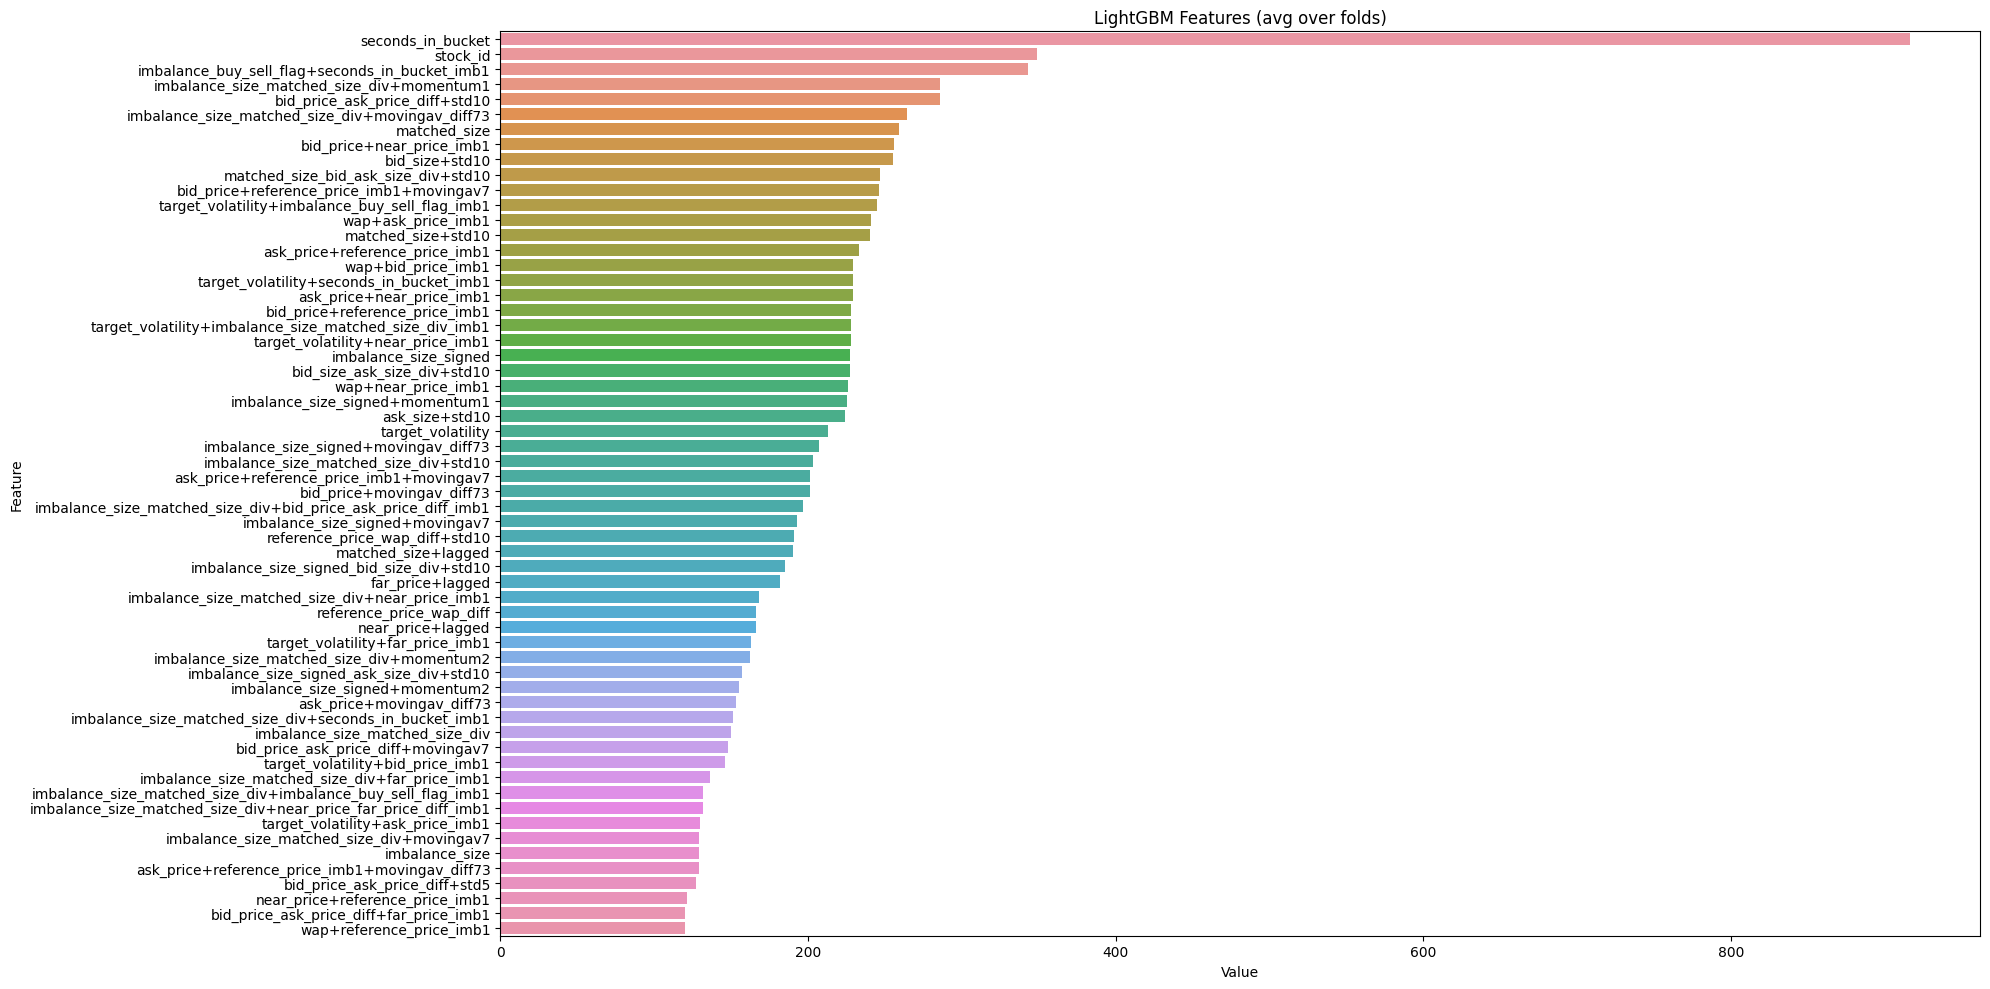

In [21]:
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=data.iloc[:60])
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()


In [22]:
pd.set_option("display.max_rows", None)

In [23]:
data

,Value,Feature
342,916,seconds_in_bucket
341,349,stock_id
340,343,imbalance_buy_sell_flag+seconds_in_bucket_imb1
339,286,imbalance_size_matched_size_div+momentum1
338,286,bid_price_ask_price_diff+std10
337,264,imbalance_size_matched_size_div+movingav_diff73
336,259,matched_size
335,256,bid_price+near_price_imb1
334,255,bid_size+std10
333,247,matched_size_bid_ask_size_div+std10


In [24]:
best_imb1_featsn = []
best_movingav_featsn = []
best_lagged_featsn = []
best_std_featsn = []
best_momentum_featsn = []
for i in data.values:
    a = i[0]
    feat = i[1]
    if a != 0:
        if ('std' in feat[:-1]):
            best_std_featsn.append(feat)
        if ('movingav' in feat[:-1]):
            best_movingav_featsn.append(feat)
        if (feat.endswith('imb1')):
            best_imb1_featsn.append(feat)
        if (feat.endswith('lagged')):
            best_lagged_featsn.append(feat)
        if ('momentum' in feat[:-1]):
            best_momentum_featsn.append(feat)

In [30]:
import optiver2023
env = optiver2023.make_env()
iter_test = env.iter_test()

In [31]:
counter = 0
last_df = []
for (test, revealed_targets, sample_prediction) in iter_test:
    test_df = feature_engineering(test, training=False, last_df=last_df)
    sample_prediction['target'] = lgbm.predict(test_df)
    env.predict(sample_prediction)
    last_df.append(test)
    if len(last_df) > 10:
        last_df = last_df[1:]
    
    counter += 1
    if not IS_ONLINE:
        print('WARNING NOT ONLINE')
    print(counter)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165


In [32]:
sample_prediction

,row_id,target
0,480_540_0,-0.835286
1,480_540_1,0.531427
2,480_540_2,0.377614
3,480_540_3,-1.136961
4,480_540_4,-0.990556
5,480_540_5,3.000994
6,480_540_6,1.965076
7,480_540_7,-0.483833
8,480_540_8,1.721857
9,480_540_9,-0.285340
